In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

import os
import tarfile
import wandb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device() 

# Wandb Login & Init

In [4]:
wandb.login(key='feaed71a1d227d1c2ec9d80e592582248a32f930', force=True)
wandb.init(project='attention')

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ee18b153 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [5]:
!wget -nc https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar

if not os.path.isdir('dakshina_dataset_v1.0'):
  tarfile.open("dakshina_dataset_v1.0.tar").extractall() 

--2021-05-02 14:17:18--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 173.194.69.128, 74.125.143.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G   187MB/s    in 9.8s    

2021-05-02 14:17:28 (196 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



In [6]:
class data_loader():

  @staticmethod
  def _load_raw_df(languages = ["hi", "mr"]):
    lex = dict()
    lex['train'], lex['val'], lex['test'] = [], [], [] 
    column_names = ['output', 'input', 'count']
    
    for la in languages:
      lex['train'].append(pd.read_csv('dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.train.tsv', sep='\t', header=None, names=column_names))
      lex['val'].append(pd.read_csv('dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.dev.tsv', sep='\t', header=None, names=column_names))
      lex['test'].append(pd.read_csv('dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.test.tsv', sep='\t', header=None, names=column_names))

    lex['train'] = pd.concat(lex['train'])
    lex['val'] = pd.concat(lex['val'])
    lex['test'] = pd.concat(lex['test'])

    return lex    

  @staticmethod
  def _make_final_df(lex):
    
    for div in ['train', 'val', 'test']:
    
      # removing non max transliterations
      idx = lex[div].groupby(['input'])['count'].transform(max) == lex[div]['count']
      lex[div] = lex[div][idx].reset_index(drop=True)

      # calclulating difference in lengths of various transliterations
      lex[div]['input_len'] = lex[div].apply(lambda x: len(str(x['input'])), axis=1)
      lex[div]['output_len'] = lex[div].apply(lambda y: len(str(y['output'])), axis=1)
      lex[div]['mod_dif'] = lex[div].apply(lambda z: abs(z['input_len'] - z['output_len']), axis=1) 

      # removing transliterations that vary by a lot in length
      idx = lex[div].groupby(['input'])['mod_dif'].transform(min) == lex[div]['mod_dif']
      lex[div] = lex[div][idx].reset_index(drop=True)

      # removing duplicates if any remain
      lex[div].drop_duplicates(subset='input', keep='first', inplace=True)

      # removing redundant columns
      lex[div].drop(labels=['count', 'input_len', 'output_len', 'mod_dif'], inplace=True, axis=1)

    return lex

In [7]:
class Tokenizer:

  def __init__(self, df):

    # special tokens
    self.start_token = '<SOW>'
    self.stop_token = '<EOW>'
    self.unknown_token = '<UNK>'

    # building vocabulary
    self.input_vocab = [self.start_token, self.stop_token, self.unknown_token]
    self.output_vocab = [self.start_token, self.stop_token, self.unknown_token]

    input_words = df.input.tolist()
    output_words = df.output.tolist()

    for word in input_words:
      tokens = str(word)
      for token in tokens:
        if token not in self.input_vocab:
          self.input_vocab.append(token)

    for word in output_words:
      tokens = str(word)
      for token in tokens:
        if token not in self.output_vocab:
          self.output_vocab.append(token)
    
    # building word2idx and idx2word dictionaries
    self.word2idx_input = {self.input_vocab[i] : i+1 for i in range(len(self.input_vocab))}
    self.idx2word_input = {k:v for v,k in self.word2idx_input.items()}
    
    self.word2idx_output = {self.output_vocab[i] : i+1 for i in range(len(self.output_vocab))}
    self.idx2word_output = {k:v for v,k in self.word2idx_output.items()}

  # takes in lists of words and returns lists of integers
  def encode(self, X, mode='input'):

    if (mode=='input'):
      input_list = []
      for word in X:
        word = str(word)
        integer_list =[self.word2idx_input.get(token, self.word2idx_input[self.unknown_token]) for token in word]
        input_list.append(torch.tensor(integer_list, device=device))
      
      # input_list = pad_sequence(input_list, batch_first=True)
      return input_list
    
    if (mode=='output'):
      output_list = []
      for word in X:
        word = str(word)
        integer_list = [self.word2idx_output.get(token, self.word2idx_output[self.unknown_token]) for token in word] + [self.word2idx_output[self.stop_token]]
        output_list.append(torch.tensor(integer_list,device=device))

      # output_list = pad_sequence(output_list, batch_first=True)
      return output_list
    
  # takes in lists of integers and returns lists of words
  def decode(self, X, mode='input'):

    if (mode=='input'):
      input_list = []
      for integers in X:
        token_list = [self.idx2word_input.get(integer, '0') for integer in integers] 
        input_list.append(''.join(token_list))
      
      return input_list

    if (mode=='output'):
      output_list = []
      for integers in X:
        token_list = [self.idx2word_output.get(integer, '0') for integer in integers[1:-1]] 
        output_list.append(''.join(token_list))
      
      return output_list

In [8]:
def return_data_dict(languages=['hi', 'mr']):

  lex = data_loader._load_raw_df(languages)
  lex = data_loader._make_final_df(lex)

  data_dict = dict()

  df_train = lex['train']
  df_val = lex['val']
  df_test = lex['test']

  tk = Tokenizer(df_train)

  data_dict['input_vocab_size'] = len(tk.input_vocab) + 1
  data_dict['output_vocab_size'] = len(tk.output_vocab) + 1

  X_train = tk.encode(df_train.input.tolist(), mode='input')
  Y_train = tk.encode(df_train.output.tolist(), mode='output')
  X_val = tk.encode(df_val.input.tolist(), mode='input')
  Y_val = tk.encode(df_val.output.tolist(), mode='output')
  X_test = tk.encode(df_test.input.tolist(), mode='input')
  Y_test = tk.encode(df_test.output.tolist(), mode='output')

  max_source_length = np.max(np.array([len(x) for x in X_train]))
  max_target_length = np.max(np.array([len(x) for x in Y_train]))

  data_dict['train'], data_dict['val'], data_dict['test']= dict(), dict(), dict()

  data_dict['train']['df'] = df_train
  data_dict['val']['df'] = df_val
  data_dict['test']['df'] = df_test

  data_dict['train']['X'] = X_train 
  data_dict['train']['Y'] = Y_train
  data_dict['val']['X'] = X_val
  data_dict['val']['Y'] = Y_val
  data_dict['test']['X'] = X_test
  data_dict['test']['Y'] = Y_test

  data_dict['train']['pairs'] = list(zip(X_train, Y_train))
  data_dict['val']['pairs'] = list(zip(X_val, Y_val))
  data_dict['test']['pairs'] = list(zip(X_test, Y_test))

  data_dict['train']['max_source_length'] = np.max(np.array([len(x) for x in X_train]))
  data_dict['train']['max_target_length'] = np.max(np.array([len(x) for x in Y_train]))
  data_dict['val']['max_source_length'] = np.max(np.array([len(x) for x in X_val]))
  data_dict['val']['max_target_length'] = np.max(np.array([len(x) for x in Y_test]))
  data_dict['test']['max_source_length'] = np.max(np.array([len(x) for x in X_test]))
  data_dict['test']['max_target_length'] = np.max(np.array([len(x) for x in Y_test]))

  data_dict['max_length'] = max([data_dict['train']['max_source_length'],
                                 data_dict['train']['max_target_length'],
                                 data_dict['val']['max_source_length'],
                                 data_dict['val']['max_target_length'],
                                 data_dict['test']['max_source_length'],
                                 data_dict['test']['max_target_length']
                                 ])

  return data_dict, tk

In [9]:
data_dict, tk = return_data_dict()

In [10]:
def to_device(data, device=device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.device = device
    self.dl = dl
  
  def __iter__(self):
    for b in self.dl:
      input_word, output_word = b
      yield to_device([torch.tensor(input_word), torch.tensor(output_word)], self.device)

  def __len__(self):
    return len(self.dl)

In [11]:
# train_dataset = [(data_dict['train']['X'][i], data_dict['train']['Y'][i]) for i in range(len(data_dict['train']['X']))]
train_dl = DataLoader(data_dict['train']['pairs'], batch_size=1)

# valid_dataset = [(data_dict['val']['X'][i], data_dict['val']['Y'][i]) for i in range(len(data_dict['val']['X']))]
valid_dl = DataLoader(data_dict['val']['pairs'], batch_size=1)

test_dl = DataLoader(data_dict['test']['pairs'], batch_size=1)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

# The Encoder

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        # print(f"Output Size: {output.size()} Hidden Size: {len(hidden)}", end='\n#####\n\n')
        output, *hidden = self.lstm(output, hidden)
        hidden = hidden[0]
        # print("Output Hidden:", hidden, sep='\n-----\n', end='\n#####\n\n')
        # print(f"LSTM Output Size: {output.size()} LSTM Hidden Size: {len(hidden)}", end='\n#####\n\n')
        # print("EXITING ENCODER!")
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device), torch.zeros(1, 1, self.hidden_size, device=device)) 

# The Decoder




In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(2, 1, 1, self.hidden_size, device=device)

# Attention Layer

In [14]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size, dropout_p=0.1, max_length=data_dict['max_length']):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.embedding_size)
        self.attn = nn.Linear(self.hidden_size + self.embedding_size, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size + self.embedding_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, *hidden = self.lstm(output, hidden)
        hidden = hidden[0]

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device), torch.zeros(1, 1, self.hidden_size, device=device))

# Training Function

In [15]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, use_teacher_forcing=True, max_length=data_dict['max_length']):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # print("Input Tensor", input_tensor, sep='\n-----\n', end='\n#####\n\n')
    # print("Output Tensor", target_tensor, sep='\n-----\n', end='\n#####\n\n')
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    # print(f"Input Length: {input_length} - Max Length: {max_length}")
    for ei in range(input_length):
        # print("One Time Step", input_tensor[ei], sep='\n-----\n', end='\n#####\n\n')

        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[1]], device=device)

    decoder_hidden = encoder_hidden

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # print("Decoder Input:", decoder_input, "Decoder Hidden:", decoder_hidden.size(), "Encoder Ouputs:", encoder_outputs.size(), sep='\n-----\n', end='\n#####\n\n')
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # print(decoder_output)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == 2:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [16]:
def evaluate_train(input_tensor, target_tensor, encoder, decoder, use_teacher_forcing=False, max_length=data_dict['max_length']):
    encoder_hidden = encoder.initHidden()

    # print("Input Tensor", input_tensor, sep='\n-----\n', end='\n#####\n\n')
    # print("Output Tensor", target_tensor, sep='\n-----\n', end='\n#####\n\n')
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    # print(f"Input Length: {input_length} - Max Length: {max_length}")
    for ei in range(input_length):
        # print("One Time Step", input_tensor[ei], sep='\n-----\n', end='\n#####\n\n')

        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[1]], device=device)

    decoder_hidden = encoder_hidden

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # print("Decoder Input:", decoder_input, "Decoder Hidden:", decoder_hidden.size(), "Encoder Ouputs:", encoder_outputs.size(), sep='\n-----\n', end='\n#####\n\n')
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # print(decoder_output)
            # loss += criterion(decoder_output, target_tensor[di])
            if not decoder_input.item() == target_tensor[di]:  # Teacher forcing
                return 0

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            if not decoder_input.item() == target_tensor[di]:
                return 0

    return 1

In [17]:
def trainIters(encoder, decoder, use_teacher_forcing=True, learning_rate=0.001, epochs=3):

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
  
    criterion = nn.NLLLoss()

    for j in range(epochs) :

      n_iters = len(train_dl)
      tqdm_object = tqdm(enumerate(train_dl, 1), total=n_iters, desc=f'Epoch {j}')

      for iter, training_pair in tqdm_object:
          input_tensor, target_tensor = training_pair[0].T, training_pair[1].T

          loss = train(input_tensor, target_tensor, encoder,
                      decoder, encoder_optimizer, decoder_optimizer, criterion, use_teacher_forcing)
          
          tqdm_object.set_postfix({'ex_loss': loss})

      with torch.no_grad():
          
          train_total_count, train_match_count = 0, 0

          for iter, training_pair in enumerate(train_dl, 1):
              input_tensor, target_tensor = training_pair[0].T, training_pair[1].T

              train_match_count += evaluate_train(input_tensor, target_tensor, encoder, decoder, use_teacher_forcing)
              train_total_count += 1
              train_acc = train_match_count/train_total_count

          val_total_count, val_match_count = 0, 0

          for iter, validation_pair in enumerate(valid_dl, 1):
              input_tensor, target_tensor = validation_pair[0].T, validation_pair[1].T

              val_match_count += evaluate_train(input_tensor, target_tensor, encoder, decoder, use_teacher_forcing)
              val_total_count += 1
              val_acc = val_match_count/val_total_count

          print(f" Training Accuracy: {train_acc*100:.4f}% - Validation Accuracy: {val_acc*100:.4f}%")
          wandb.log({'epoch': j, 
                     'train_acc': train_acc,
                     'val_acc': val_acc
                    })


# Training

In [18]:
tk.encode(['hello'])

[tensor([16, 13, 12, 12, 20], device='cuda:0')]

In [19]:
embedding_size = 20
hidden_size = 256
encoder1 = EncoderRNN(tk.input_vocab.__len__()+1, embedding_size, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(embedding_size, hidden_size, tk.output_vocab.__len__()+1, dropout_p=0.1).to(device)

In [20]:
trainIters(encoder1, attn_decoder1, use_teacher_forcing=True, epochs=2)

Epoch 0:   0%|          | 0/88528 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
Epoch 1:   0%|          | 4/88528 [00:00<40:03, 36.84it/s, ex_loss=1.66]

 Training Accuracy: 0.0000% - Validation Accuracy: 0.0000%


Epoch 1: 100%|██████████| 88528/88528 [42:28<00:00, 34.73it/s, ex_loss=5.91]


 Training Accuracy: 0.0000% - Validation Accuracy: 0.0000%


In [21]:
trainIters(encoder1, attn_decoder1, use_teacher_forcing=False, epochs=2)

Epoch 0:   0%|          | 0/88528 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
Epoch 1:   0%|          | 6/88528 [00:00<30:25, 48.49it/s, ex_loss=3]   

 Training Accuracy: 0.5140% - Validation Accuracy: 0.4044%


Epoch 1: 100%|██████████| 88528/88528 [41:06<00:00, 35.90it/s, ex_loss=6.69]


 Training Accuracy: 1.3510% - Validation Accuracy: 1.3852%


# Evaluation

In [22]:
def evaluate(encoder, decoder, word, max_length=data_dict['train']['max_source_length']):
    with torch.no_grad():

        input_tensor = tk.encode([word])[0].T
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
          
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[1]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_chars = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == 2:
                decoded_chars.append('<EOW>')
                break
            else:
                decoded_chars.append(tk.idx2word_output[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_chars, decoder_attentions[:di + 1]


In [23]:
def evaluateRandomly(encoder, decoder):
    pair = ['adam']
    print('>', pair[0])
    output_words, attentions = evaluate(encoder, decoder, pair[0])
    output_word= ''.join(output_words)
    print('<', output_word)
    print('')

In [24]:
evaluateRandomly(encoder1, attn_decoder1)

> adam
< सदाम<EOW>



In [25]:
def evaluate_test(encoder, decoder, use_teacher_forcing=True, learning_rate=0.001, epochs=3):

    with torch.no_grad():

          train_total_count, train_match_count = 0, 0
          n_iters = len(train_dl)
          tqdm_object = tqdm(enumerate(train_dl, 1), total=n_iters, desc=f'Train')

          for iter, training_pair in tqdm_object:
              input_tensor, target_tensor = training_pair[0].T, training_pair[1].T

              train_match_count += evaluate_train(input_tensor, target_tensor, encoder, decoder, use_teacher_forcing)
              train_total_count += 1
              train_acc = train_match_count/train_total_count

          valid_total_count, valid_match_count = 0, 0
          n_iters = len(valid_dl)
          tqdm_object = tqdm(enumerate(valid_dl, 1), total=n_iters, desc=f'Valid')

          for iter, validation_pair in tqdm_object:
              input_tensor, target_tensor = validation_pair[0].T, validation_pair[1].T

              valid_match_count += evaluate_train(input_tensor, target_tensor, encoder, decoder, use_teacher_forcing)
              valid_total_count += 1
              valid_acc = valid_match_count/valid_total_count

          test_total_count, test_match_count = 0, 0
          n_iters = len(test_dl)
          tqdm_object = tqdm(enumerate(test_dl, 1), total=n_iters, desc=f'Test')

          for iter, testing_pair in tqdm_object:
              input_tensor, target_tensor = testing_pair[0].T, testing_pair[1].T

              test_match_count += evaluate_train(input_tensor, target_tensor, encoder, decoder, use_teacher_forcing)
              test_total_count += 1
              test_acc = test_match_count/test_total_count

          print(f" Training Accuracy: {train_acc*100:.4f}% - Validation Accuracy: {valid_acc*100:.4f}% - Testing Accuracy: {test_acc*100:.4f}%")
          wandb.log({'use_teacher_forcing': use_teacher_forcing,
                     'train_acc': train_acc,
                     'val_acc': valid_acc,
                     'test_acc': test_acc
                   })

In [26]:
evaluate_test(encoder1, attn_decoder1, True)

Train:   0%|          | 0/88528 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
Test: 100%|██████████| 10041/10041 [00:28<00:00, 352.60it/s]


 Training Accuracy: 0.0000% - Validation Accuracy: 0.0000% - Testing Accuracy: 0.0000%


In [27]:
evaluate_test(encoder1, attn_decoder1, False)

Train:   0%|          | 0/88528 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
Test: 100%|██████████| 10041/10041 [00:32<00:00, 310.18it/s]

 Training Accuracy: 1.3521% - Validation Accuracy: 1.4156% - Testing Accuracy: 1.2648%


Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




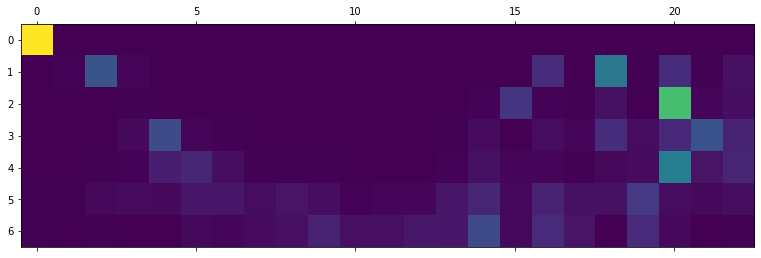

In [28]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "topper")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




input = aniswar
output = स्निस्र<EOW>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2360 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2381 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2344 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Gly

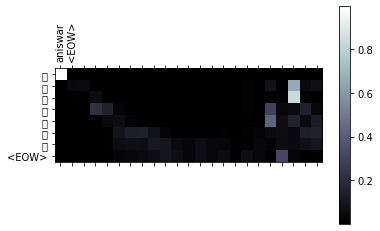

input = elephant
output = े्लिफनटट<EOW>


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2375 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2347 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2335 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 2375 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 2354 missing from current font.
  font.set_text(s, 

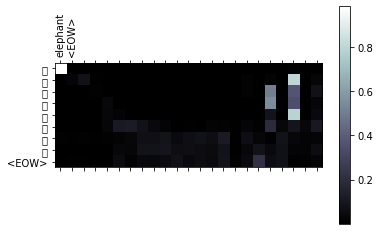

input = dragon
output = व्रोगगन<EOW>


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2357 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2379 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2327 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 2357 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 2379 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 2327 missing from current font.
  font.set_text(s, 0,

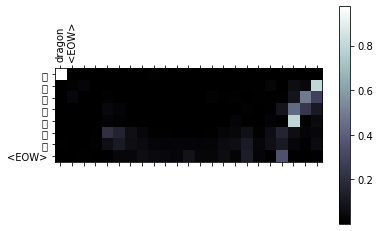

input = tiger
output = सेगेर<EOW>


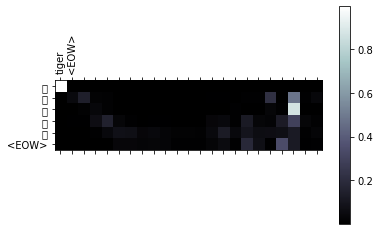

In [29]:
def showAttention(input_word, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_word.split(' ') +
                       ['<EOW>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    wandb.log({f'image+{input_word}': wandb.Image(fig)})
    plt.show()


def evaluateAndShowAttention(input_word):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_word)
    print('input =', input_word)
    print('output =', ''.join(output_words))
    showAttention(input_word, output_words, attentions)
    


evaluateAndShowAttention("aniswar")

evaluateAndShowAttention("elephant")

evaluateAndShowAttention("dragon")

evaluateAndShowAttention("tiger")

Exercises
=========

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pre-trained word embeddings such as word2vec or
   GloVe
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there




In [30]:
for j in "nan" :
  print(j)

n
a
n
